In [1]:
%load_ext cython

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [21]:
%%cython -a -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable

cdef RndmWrapper rndm = RndmWrapper((1234, 0)) # global variable
    
cdef void init_spins(long[::1] spins): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2 , int L3 = 1):
  
    if L3 == 1:
        for i in range(L1*L2):
            Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
            Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
            Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
            Js[i, (i + L2) % (L1*L2)] = J
            Js[i, (i // L2) * L2 + (i - 1) % L2] = J
            Js[i, (i - L2) % (L1*L2)] = J
        return
    
    else:
        return
    
def det_energies(double J, double Jd): # возвращает энергии для всех возможных конфигураций системы 4х4
    
    cdef int L = 4
    
    cdef long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang')
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)
    
    A = [-1,1]
    conf = [(a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16) for a1 in A for a2 in A for a3 in A for a4 in A for a5 in A for a6 in A for a7 in A for a8 in A for a9 in A for a10 in A for a11 in A for a12 in A for a13 in A for a14 in A for a15 in A for a16 in A]
    cdef long[:,::1] configs = np.asarray(conf) # перебор всех конфигураций
    
    energies = []
    magns = []
    cdef int i
    for i in range(2**16):
        energies.append(energy(configs[i], neighbors, Js))
        magns.append((np.sum(configs[i]))**2)
        
    
        
    return (np.asarray(energies),np.asarray( magns))
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        int num_therm = int(1e4)
        int num_prnt = 10000
        int steps_per_sweep = 100
        int step = 0, sweep = 0
        int i
        double av_en = 0., Z = 0., magn = 0., av_magn=0.

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            step += 1
            flip_spin(spins, neighbors, beta, Js)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            step += 1
            flip_spin(spins, neighbors, beta, Js)
            
        av_en += energy(spins, neighbors, Js)
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
        av_magn += magn**2
        Z += 1
    
    
    return (av_en/Z , av_magn/Z)
  

In [ ]:
# Средняя энергия полученных конфигураций от температуры

In [14]:
Temps = np.linspace(0.5, 7, 100)

In [5]:
ene = []
ene_01 = []
ene_05 = []
for t in Temps:
    ene.append(simulate(4,t,1,0,20000)[0])
    ene_01.append(simulate(4,t,1,-0.1,20000)[0])
    ene_05.append(simulate(4,t,1,-0.5,20000)[0])

In [ ]:
# считаю матожидание энергии через статсумму

In [6]:
def av_energy(beta, Energy):
    
    E = 0
    Z = 0
    for i in range(2**16):
        Z += math.exp(-1 * Energy[i] * beta)
        E += Energy[i] * math.exp(-1 * Energy[i] * beta)
        
    return E/Z
    

In [7]:
Energies = det_energies(1,0)[0]
exact_energy = []
for t in Temps:
    exact_energy.append(av_energy(1/t, Energies))

In [8]:
Energies_01 = det_energies(1,-0.1)[0]
exact_energy_01 = []
for t in Temps:
    exact_energy_01.append(av_energy(1/t, Energies_01))

In [9]:
Energies_05 = det_energies(1,-0.5)[0]
exact_energy_05 = []
for t in Temps:
    exact_energy_05.append(av_energy(1/t, Energies_05))

In [13]:
# пунктирные линии обозначают теоретические значения энергии, полученные с помощью статсуммы.
# непрерывные линии - средние значения энергии для конфигураций генератора.

Text(0, 0.5, 'Average energy')

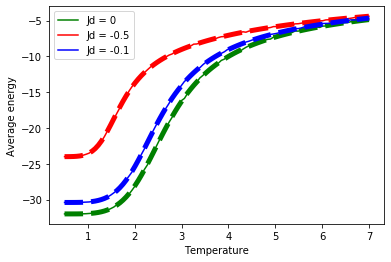

In [12]:
plt.plot(Temps, ene, label = 'Jd = 0', color = 'green')
plt.plot(Temps, exact_energy, color = 'green', ls = '--',linewidth=5)
plt.plot(Temps, ene_05, label = 'Jd = -0.5', color = 'red')
plt.plot(Temps, exact_energy_05, ls = '--', color = 'red', linewidth=5)
plt.plot(Temps, ene_01, label = 'Jd = -0.1', color = 'blue')
plt.plot(Temps, exact_energy_01, ls = '--', color = 'blue', linewidth=5)
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Average energy")

In [ ]:
# графики зависимости квадрата намагниченности от температуры

In [23]:
def av_magn(beta, magnetization, Energy):
    
    M = 0
    Z = 0
    for i in range(2**16):
        Z += math.exp(-1 * Energy[i] * beta)
        M += magnetization[i] * math.exp(-1 * Energy[i] * beta)
        
    return M/Z
    

In [24]:
Energies, m2s = det_energies(1,0)
exact_m2 = []
for t in Temps:
    exact_m2.append(av_magn(1/t, m2s, Energies))

In [25]:
Energies_01, m2s_01 = det_energies(1,-0.1)
exact_m2_01 = []
for t in Temps:
    exact_m2_01.append(av_magn(1/t, m2s_01, Energies_01))

In [26]:
Energies_05, m2s_05 = det_energies(1,-0.5)
exact_m2_05 = []
for t in Temps:
    exact_m2_05.append(av_magn(1/t, m2s_05, Energies_05))

In [18]:
mag = []
mag_01 = []
mag_05 = []
for t in Temps:
    mag.append(simulate(4,t,1,0,20000)[1])
    mag_01.append(simulate(4,t,1,-0.1,20000)[1])
    mag_05.append(simulate(4,t,1,-0.5,20000)[1])

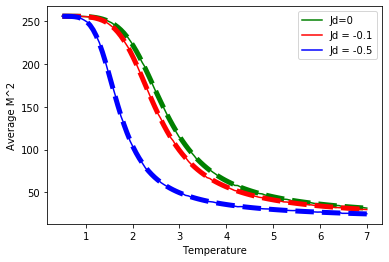

In [27]:
plt.plot(Temps, mag, label = "Jd=0", color = 'green')
plt.plot(Temps, exact_m2, color = 'green', ls = '--',linewidth=5)
plt.plot(Temps, mag_01, label = "Jd = -0.1", color = 'red')
plt.plot(Temps, exact_m2_01, color = 'red', ls = '--',linewidth=5)
plt.plot(Temps, mag_05, label = "Jd = -0.5", color = 'blue')
plt.plot(Temps, exact_m2_05, color = 'blue', ls = '--',linewidth=5)
plt.xlabel("Temperature")
plt.ylabel("Average M^2")
plt.legend()

In [ ]:
# решаю уравнение для крит температуры при различных Jd/J

In [7]:
from scipy import optimize

In [49]:
def F(t):
    Jd = 0
    return (np.sinh(2/t))**2 + 2 * np.sinh(2/t) * np.sinh(Jd *2/t) - 1

In [55]:
sol=optimize.root(F,1).x[0]

In [57]:
roots.append(sol)

In [ ]:
# так посчитала для Jd от -1 до 0 с шагом 0.1

In [4]:
roots = sorted(roots)

In [5]:
roots

[0.03198372863548067,
 0.2885386111960936,
 0.5762735442012712,
 0.8541630993606272,
 1.109960313758399,
 1.34187327905057,
 1.5536238493280832,
 1.749339162933206,
 1.932307699120554,
 2.104982167992544,
 2.2691853142129728]

In [2]:
roots = [2.2691853142129728,
 2.104982167992544,
 1.932307699120554,
 1.749339162933206,
 1.5536238493280832,
 1.34187327905057,
 1.109960313758399,
 0.8541630993606272,
 0.5762735442012712,
 0.2885386111960936,
 0.03198372863548067]

Text(0, 0.5, 'T critical')

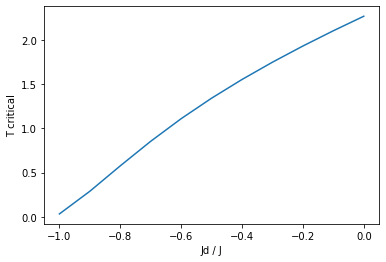

In [6]:
plt.plot(np.linspace(-1,0,11), roots)

plt.xlabel("Jd / J")
plt.ylabel("T critical")